In [99]:
# install.packages("bbmle")
# install.packages("readxl")
# install.packages("gridExtra")
# install.packages("ggplot2")
# install.packages("egg")

In [74]:
library("bbmle")
library("readxl")
library("gridExtra")
library("ggplot2")
library("egg")

In [94]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)

Warning message in mle2(parental_effect_log_likelihood, start = list(beta_m_0 = beta_m_0_ini, :
“some parameters are on the boundary: variance-covariance calculations based on Hessian may be unreliable”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in mle2(parental_effect_log_likelihood, start = list(beta_m_0 = beta_m_0_ini, :
“some parameters are on the boundary: variance-covariance calculations based on Hessian may be unreliable”
Warning message in mle2(parental_effect_log_likelihood, start = list(beta_m_0 = beta_m_0_ini, :
“some parameters are on the boundary: variance-covariance calculations based on Hessian may be unreliable”
Warning message in mle2(parental_effect_log_likelihood, start = list(beta_m_0 = beta_m_0_ini, :
“some parameters are on the boundary: variance-covariance calculations based on Hessian may be unreliable”
Warning message in mle2(parental_effect_log_likelihood, start = list(beta_m_0 = beta_m_0_ini, :
“some parameters are on the boun

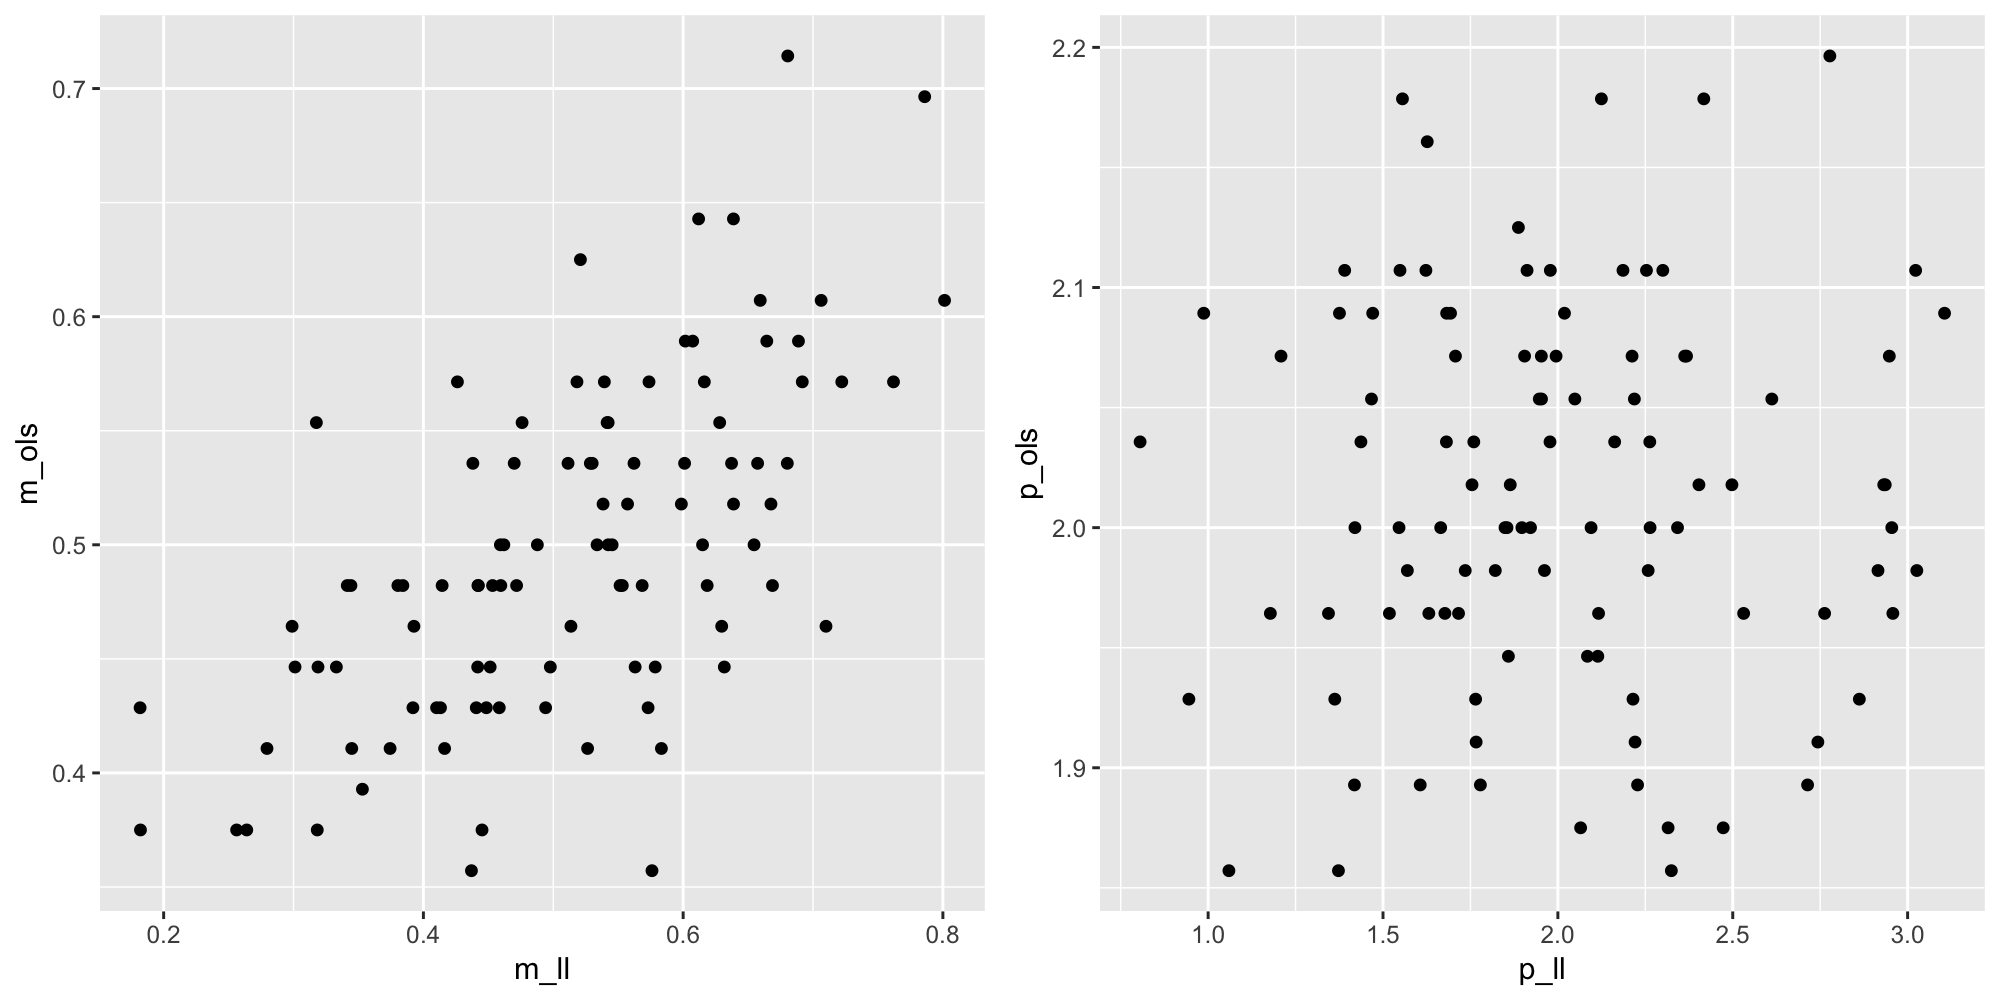

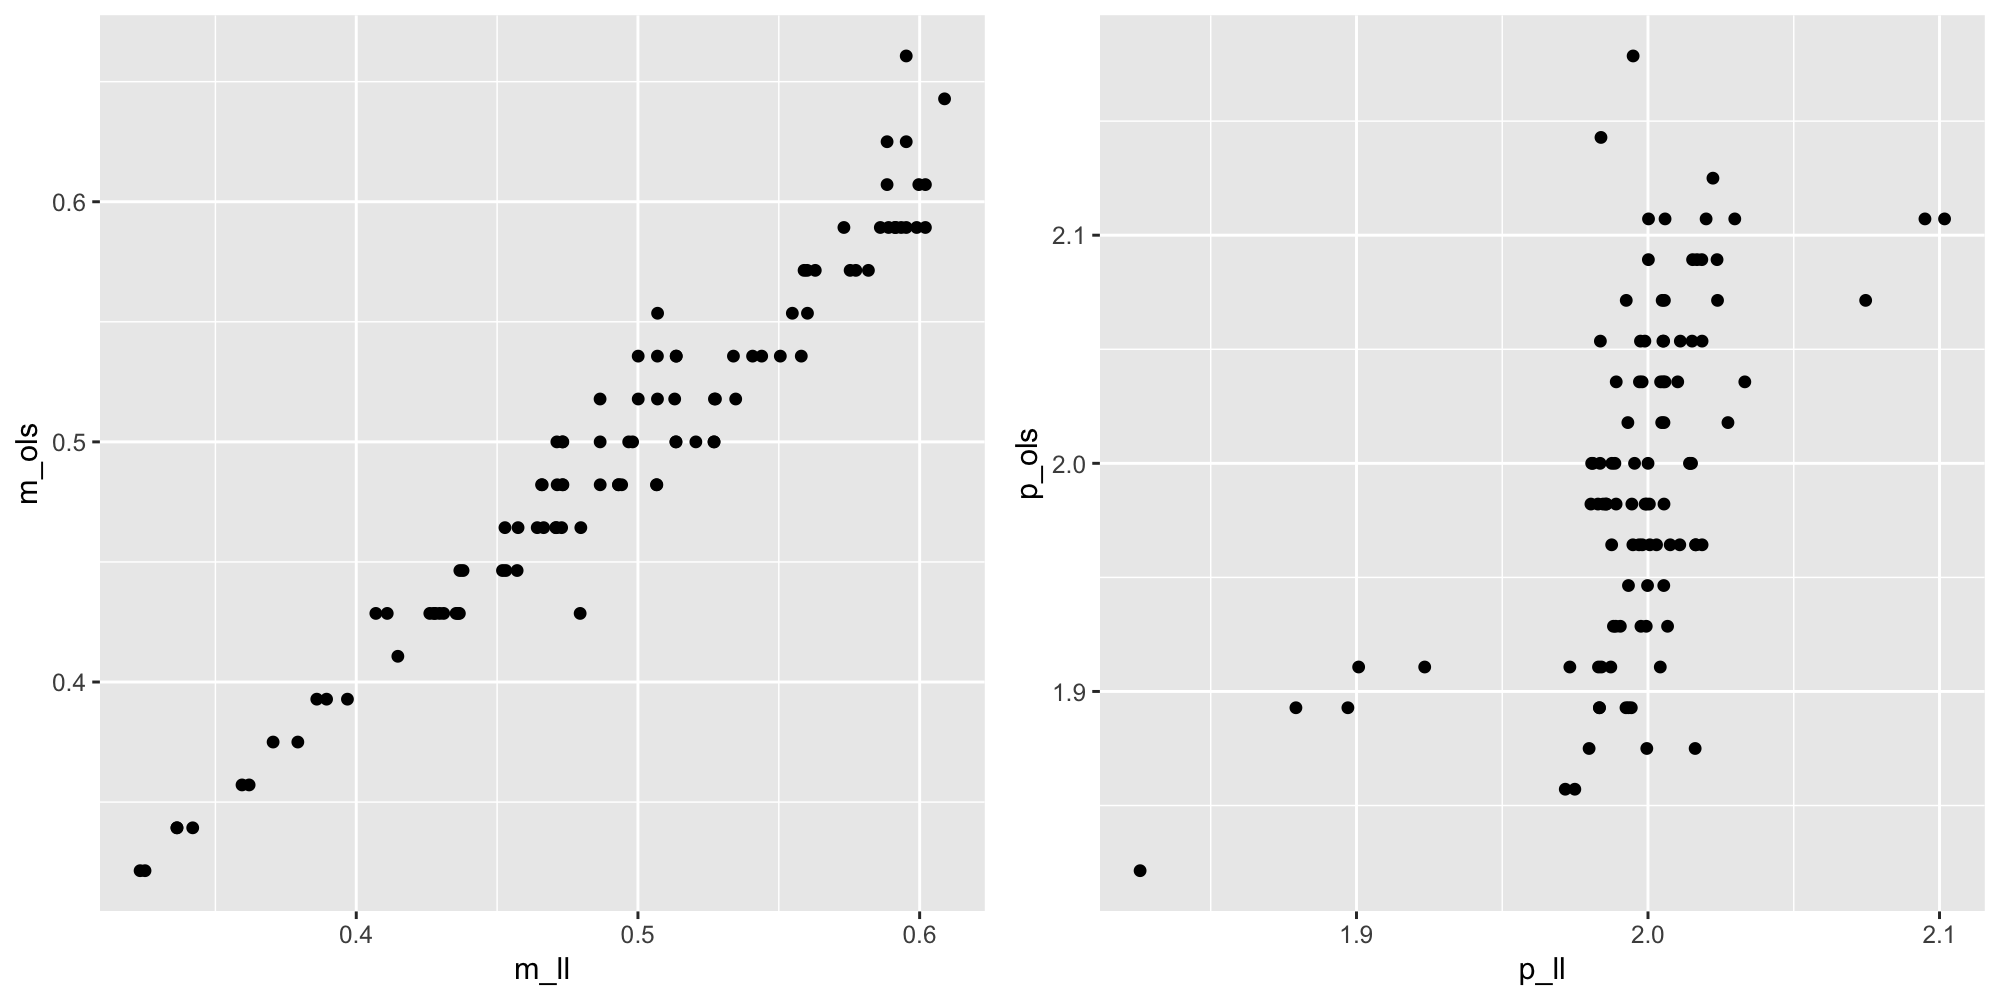

In [114]:
generate_test_data_no_unphased <- function() {
    df <- data.frame(
        paternal_age=c(20, 22, 24, 26, 28, 30, 32), 
        maternal_age=c(15, 17, 19, 21, 23, 25, 27)
    )
    n_datapoints <- length(df$paternal_age)
    df$paternal_count <- 2 * df$paternal_age + 5 + sample(c(-1, 0, 1), size = n_datapoints, replace = TRUE)
    df$maternal_count <- 0.5 * df$maternal_age + 2 + sample(c(-1, 0, 1), size = n_datapoints, replace = TRUE)

    df$total <- df$paternal_count + df$maternal_count
    df$unphased_count <- df$total - df$paternal_count - df$maternal_count
    return(df)
}

generate_test_data_2 <- function() {
    df <- data.frame(
        paternal_age=c(20, 22, 24, 26, 28, 30, 32), 
        maternal_age=c(15, 17, 19, 21, 23, 25, 27)
    )
    n_datapoints <- length(df$paternal_age)
    df$paternal_count <- 2 * df$paternal_age + 5 + sample(c(-1, 0, 1), size = n_datapoints, replace = TRUE)
    df$maternal_count <- 0.5 * df$maternal_age + 2 + sample(c(-1, 0, 1), size = n_datapoints, replace = TRUE)
    df$unphased_count <- sample(20:40, size = n_datapoints, replace = TRUE)
    df$total <- df$paternal_count + df$maternal_count + df$unphased_count
    return(df)
}

df_no_unphased <- generate_test_data_no_unphased()
df_simulated_with_unphased <- generate_test_data_2()

parental_effect_log_likelihood <- function(beta_m_0, beta_m_1, beta_p_0, beta_p_1, x) {
    # paternal_count, maternal_count, unphased_count, paternal_age, maternal_age, 
    paternal_count <- x$paternal_count
    maternal_count <- x$maternal_count
    unphased_count <- x$unphased_count
    paternal_age <- x$paternal_age
    maternal_age <- x$maternal_age

    maternal_reg_term = beta_m_0 + beta_m_1 * maternal_age
    paternal_reg_term = beta_p_0 + beta_p_1 * paternal_age
    if (any(maternal_reg_term <= 0)) {
        cat(beta_m_0, beta_m_1, maternal_reg_term)
    }
    return(-sum(maternal_count * log(maternal_reg_term) + paternal_count * log(paternal_reg_term) + unphased_count * log(maternal_reg_term + paternal_reg_term) - (maternal_reg_term + paternal_reg_term)))
}

estimate_paternal_maternal_effects <- function(df, beta_m_0_ini, beta_m_1_ini, beta_p_0_ini, beta_p_1_ini, print_output=FALSE) {
    m_ll <- mle2(
        parental_effect_log_likelihood, start=list(beta_m_0=beta_m_0_ini, beta_m_1=beta_m_1_ini, beta_p_0=beta_p_0_ini, beta_p_1=beta_p_1_ini), 
        lower=c(1e-8,1e-8,1e-8,1e-8), upper=c(Inf,Inf,Inf,Inf), method="L-BFGS-B", data=list(x=df)
        )
    coef_ll <- coef(summary(m_ll))
    beta_m_0_ll_est <- coef_ll[[1]]
    beta_m_1_ll_est <- coef_ll[[2]]
    beta_p_0_ll_est <- coef_ll[[3]]
    beta_p_1_ll_est <- coef_ll[[4]]

    m_p = lm(paternal_count ~ paternal_age, data=df)
    m_m = lm(maternal_count ~ maternal_age, data=df)
    beta_m_0_ols_est <- coef(summary(m_m))[[1]]
    beta_m_1_ols_est <- coef(summary(m_m))[[2]]
    beta_p_0_ols_est <- coef(summary(m_p))[[1]]
    beta_p_1_ols_est <- coef(summary(m_p))[[2]]
    if (print_output) {
        cat("maternal effect (intercept) estimate log likelihood: ",  beta_m_0_ll_est, "OLS: ", beta_m_0_ols_est, "\n")
        cat("paternal effect (intercept) estimate log likelihood: ",  beta_p_0_ll_est, "OLS: ", beta_p_0_ols_est, "\n")
        cat("maternal effect (slope) estimate log likelihood: ",  beta_m_1_ll_est, "OLS: ", beta_m_1_ols_est, "\n")
        cat("paternal effect (slope) estimate log likelihood: ",  beta_p_1_ll_est, "OLS: ", beta_p_1_ols_est, "\n")
        cat("paternal / maternal ratio: ", beta_p_1_ll_est / beta_m_1_ll_est, "OLS: ", beta_p_1_ols_est / beta_m_1_ols_est, "\n")
    }
    return(c(beta_m_1_ll_est, beta_p_1_ll_est, beta_m_1_ols_est, beta_p_1_ols_est)) #, beta_m_0_ll_est, beta_p_0_ll_est, beta_m_0_ols_est, beta_p_0_ols_est))
}

compare_ols_vs_ll_estimates <- function(data_generating_function) {
    plot_data = data.frame()

    for (i in 1:100) {
        df_data <- data_generating_function()
        estimates <- estimate_paternal_maternal_effects(df_data, 2, 0.5, 5, 2)
        row <- data.frame(m_ll = estimates[1], p_ll = estimates[2], m_ols = estimates[3], p_ols = estimates[4])
        plot_data <- rbind(plot_data, row)
    }
    p1 <- ggplot(plot_data, aes(x = m_ll, y = m_ols)) + geom_point() 
    p2 <- ggplot(plot_data, aes(x = p_ll, y = p_ols)) + geom_point() 

    grid.arrange(p1, p2, ncol=2)
}

compare_ols_vs_ll_estimates(generate_test_data_2)
compare_ols_vs_ll_estimates(generate_test_data_no_unphased)

In [113]:
df_ayeaye_wang <- read.csv("./output/phased_counts/ayeaye_wang_phased_counts.csv")
df_ayeaye_wang$paternal_age <- df_ayeaye_wang$paternal_age - 3
df_ayeaye_wang$maternal_age <- df_ayeaye_wang$maternal_age - 3
ayeaye_output <- estimate_paternal_maternal_effects(df_ayeaye_wang, 1, 1, 8, 0.1, print_output=TRUE)
print(ayeaye_output)

Warning message in mle2(parental_effect_log_likelihood, start = list(beta_m_0 = beta_m_0_ini, :
“some parameters are on the boundary: variance-covariance calculations based on Hessian may be unreliable”


maternal effect (intercept) estimate log likelihood:  1e-08 OLS:  -4.720664 
paternal effect (intercept) estimate log likelihood:  18.04446 OLS:  7.789456 
maternal effect (slope) estimate log likelihood:  2.45706 OLS:  1.145687 
paternal effect (slope) estimate log likelihood:  0.6805108 OLS:  0.1145923 
paternal / maternal ratio:  0.2769615 OLS:  0.1000206 
[1] 2.4570595 0.6805108 1.1456873 0.1145923


In [ ]:
df_chimp <- data.frame(total=c(45, 57, 18, 42, 18, 28, 55),
    paternal_count=c(11, 17, 7, 16, 3, 10, 19),
    maternal_count=c(5, 5, 1, 1, 1, 1, 5), 
    paternal_age=c(21, 23.9, 14.7, 20.22, 15.63, 18.39, 21.07), 
    maternal_age=c(21, 15.89, 14.79, 12.22, 15.72, 18.48, 13.06)
    )
df_chimp$unphased_count <- df_chimp$total - df_chimp$paternal_count - df_chimp$maternal_count
df_chimp$corrected_paternal_age <- df_chimp$paternal_age - 13
df_chimp$corrected_maternal_age <- df_chimp$maternal_age - 12



m_ll <- mle2(
    parental_effect_log_likelihood, start=list(beta_m_0=2.4, beta_m_1=0.2, beta_p_0=3.95, beta_p_1=1.5), 
    lower=c(1e-8,1e-8,1e-8,1e-8), upper=c(Inf,Inf,Inf,Inf), method="L-BFGS-B", data=list(x=df_chimp)
    )

In [85]:
print(coef(summary(m_ll)))

          Estimate Std. Error   z value        Pr(z)
beta_m_0 5.8827211  2.2935734 2.5648715 1.032140e-02
beta_m_1 0.2457234  0.4778286 0.5142501 6.070771e-01
beta_p_0 4.1849691  3.7596526 1.1131265 2.656541e-01
beta_p_1 4.2325783  0.6518537 6.4931419 8.406445e-11


In [83]:
beta_m_0_step <- 0.2 
beta_m_1_step <- 0.2 
beta_p_0_step <- 0.2 
beta_p_1_step <- 0.2 

beta_m_0_seq <- seq(1e-8, 10, beta_m_0_step)
beta_m_1_seq <- seq(1e-8, 10, beta_m_1_step)
beta_p_0_seq <- seq(1e-8, 10, beta_p_0_step)
beta_p_1_seq <- seq(1e-8, 10, beta_p_1_step)
grid_size <- length(beta_m_0_seq) * length(beta_m_1_seq) * length(beta_p_0_seq) * length(beta_p_1_seq)
 
neg_ll_min <- Inf
max_index <- c(-1,-1,-1,-1)
for (m0 in beta_m_0_seq) {
    for (m1 in beta_m_1_seq) {
        for (p0 in beta_p_0_seq) {
            for (p1 in beta_p_1_seq) {
                neg_ll <- parental_effect_log_likelihood(m0, m1, p0, p1, chimp)
                if (neg_ll < neg_ll_min) {
                    neg_ll_min <- neg_ll
                    max_index <- c(m0, m1, p0, p1)
                }
            }
        }
    }
}
print(neg_ll_min)
print(max_index)


[1] -660.0111
[1] 6.0 0.2 4.4 4.2
